In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from astsadata import *

/mnt/d/work/tsa4-python/.venv/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:1101: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


In [2]:
def acf1(x, nlags=None, acf_type="correlation", pacf=False, ax=None, **kwargs):
    lags = np.arange(1, nlags + 1)

    if pacf:
        if acf_type == "correlation":
            values = sm.tsa.pacf(x, nlags=nlags)[1:]
            ylabel = "PACF"
    else:
        if acf_type == "correlation":
            values = sm.tsa.acf(x, nlags=nlags, fft=False)[1:]
            ylabel = "ACF"
        elif acf_type == "covariance":
            values = sm.tsa.acovf(x, nlag=nlags)[1:]
            ylabel = "ACoV"

    if ax is None:
        ax = plt.gca()
 
    ax.bar(lags, values, **kwargs)
    ax.axhline(0, color="black", linewidth=1)
    if acf_type == "correlation":
        conf_level = 1.96 / np.sqrt(x.shape[0])
        ax.axhline(conf_level, color="red", linestyle="--", linewidth=1)
        ax.axhline(-conf_level, color="red", linestyle="--", linewidth=1)
    ax.set_xlabel("LAG")
    ax.set_ylabel(ylabel)

    return ax

In [3]:
def ccf(x, y, max_lag, ccf_type="correlation", ax=None, **kwargs):
    lags = np.arange(-max_lag, max_lag + 1)

    if ccf_type == "correlation":
        backwards = sm.tsa.ccf(x[::-1], y[::-1], adjusted=False)[max_lag::-1]
        forwards = sm.tsa.ccf(x, y, adjusted=False)[:max_lag + 1]
        ccf = np.r_[backwards[:-1], forwards]
        ylabel = "CCF"
    elif ccf_type == "covariance":
        backwards = sm.tsa.ccovf(x[::-1], y[::-1], adjusted=False)[max_lag::-1]
        forwards = sm.tsa.ccovf(x, y, adjusted=False)[:max_lag + 1]
        ccf = np.r_[backwards[:-1], forwards]
        ylabel = "CCoV"

    if ax is None:
        ax = plt.gca()
    
    ax.bar(lags, ccf, **kwargs)
    ax.axhline(0, color="black", linewidth=1)
    ax.axvline(0, color="black", linestyle="--", linewidth=1)
    if ccf_type == "correlation":
        conf_level = 1.96 / np.sqrt(x.shape[0])
        ax.axhline(conf_level, color="red", linestyle="--", linewidth=1)
        ax.axhline(-conf_level, color="red", linestyle="--", linewidth=1)
    ax.set_xlabel("LAG")
    ax.set_ylabel(ylabel)

    return ax

# 1.5 Estimation of Correlation

First 6 sample acf values: [ 0.60410089  0.37379533  0.21412447  0.05013659 -0.10703704 -0.18698742]


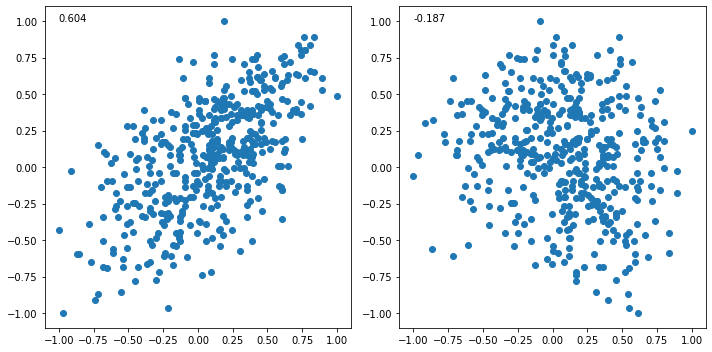

In [4]:
# Example 1.25
# Lags 1 and 6 of soi series
r = sm.tsa.acf(soi, nlags=6, fft=False)[1:]
print("First 6 sample acf values:", r)

fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
axes[0].scatter(soi.shift(1), soi)
axes[0].text(-1, 1, round(r[0], 3))
axes[1].scatter(soi.shift(6), soi)
axes[1].text(-1, 1, round(r[5], 3))
fig.tight_layout()
plt.show()

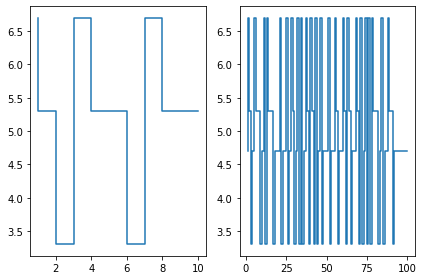

5.319999999999999 4.957999999999999
[-0.40187374 -0.20011531 -0.05975786  0.42940329]
[-0.39017986 -0.16249786  0.12187033 -0.14029152]


In [5]:
# Example 1.26
np.random.seed(101010)
# Bernoulli (0, 1) distribution convert (0, 1) to (-1, 1)
x1 = pd.Series(2 * np.random.binomial(n=1, p=.5, size=11) - 1) # simulated sequence of coin tosses
x2 = pd.Series(2 * np.random.binomial(n=1, p=.5, size=101) - 1)
# apply filter and add 5
y1 = 5 + sm.tsa.filters.convolution_filter(x1, filt=[1, -.7], nsides=1).dropna()
y2 = 5 + sm.tsa.filters.convolution_filter(x2, filt=[1, -.7], nsides=1).dropna()

# Plot the new series
fig, axes = plt.subplots(ncols=2)
axes[0].step(y1.index, y1.values)
axes[1].step(y2.index, y2.values)
fig.tight_layout()
plt.show()

# Means of both should be around 5
print(y1.mean(axis=0), y2.mean(axis=0)) # the sample

# Print the first 5 lags of sample autocorrelations of these two series
print(sm.tsa.acf(y1, nlags=4, fft=False)[1:])
print(sm.tsa.acf(y2, nlags=4, fft=False)[1:])

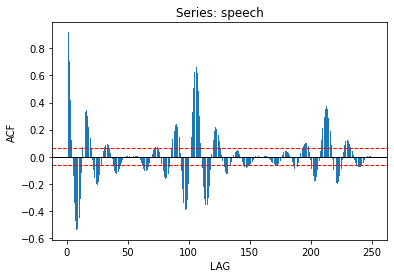

In [6]:
# Example 1.27
ax = acf1(speech, nlags=250)
ax.set_title("Series: speech")
plt.show()

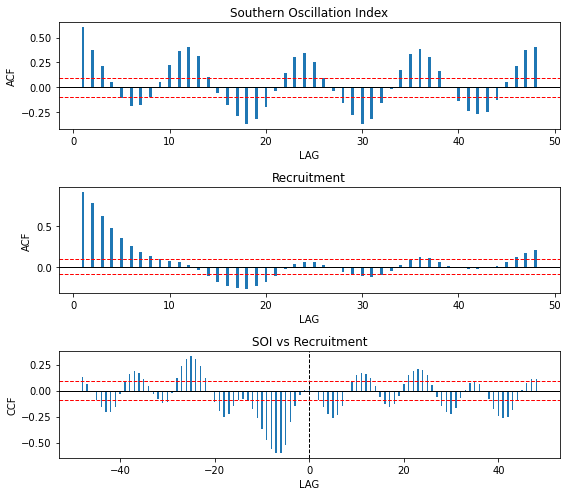

In [7]:
# Example 1.28
fig, axes = plt.subplots(nrows=3, figsize=(8, 7))

acf1(soi, nlags=48, ax=axes[0], width=.3)
axes[0].set_title("Southern Oscillation Index")

acf1(rec, nlags=48, ax=axes[1], width=.3)
axes[1].set_title("Recruitment")

ccf(soi, rec, max_lag=48, ax=axes[2], width=.3)
axes[2].set_title("SOI vs Recruitment")

fig.tight_layout()
plt.show()

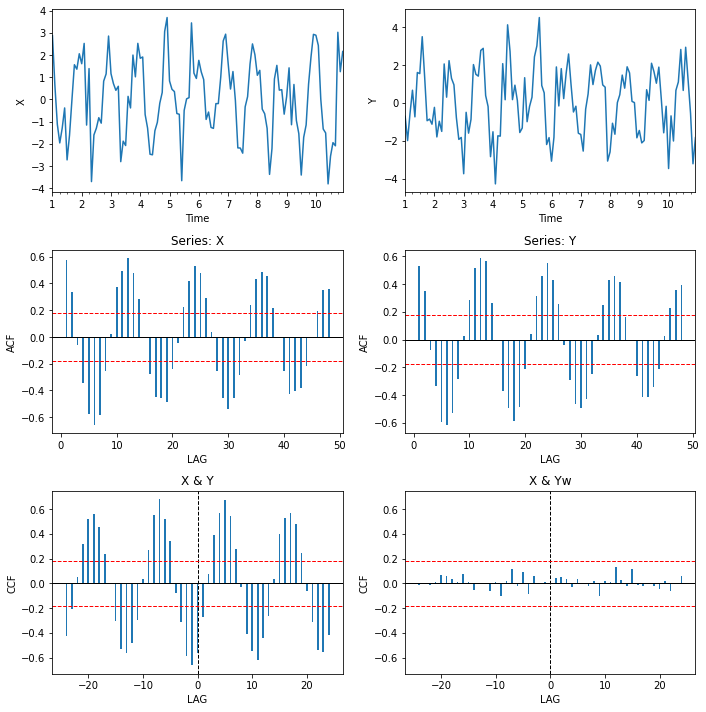

In [8]:
# Example 1.29
np.random.seed(1492)
num = 120
t = np.arange(1, num + 1)
X = pd.Series(2 * np.cos(2 * np.pi * t / 12) + np.random.normal(size=num), 
              index=pd.period_range('0001-01', periods=num, freq="M")) 
Y = pd.Series(2 * np.cos(2 * np.pi * (t + 5) / 12) + np.random.normal(size=num), 
              index=pd.period_range('0001-01', periods=num, freq="M"))

cos_x = pd.Series(np.cos(2 * np.pi * t/12), index=Y.index)
sin_x = pd.Series(np.sin(2 * np.pi * t/12), index=Y.index)
data_reg = pd.concat([Y, cos_x, sin_x], axis=1)
data_reg.columns = ["Y", "cos_x", "sin_x"]

fit = ols("Y ~ cos_x + sin_x", data=data_reg).fit()

Yw = fit.resid

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))
X.plot(ax=axes[0, 0], xlabel="Time", ylabel="X")
Y.plot(ax=axes[0, 1], xlabel="Time", ylabel="Y")

acf1(X, nlags=48, ax=axes[1, 0], width=.3)
axes[1, 0].set_title("Series: X")

acf1(Y, nlags=48, ax=axes[1, 1], width=.3)
axes[1, 1].set_title("Series: Y")

ccf(X, Y, max_lag=24, ax=axes[2, 0], width=.3)
axes[2, 0].set_title("X & Y")

ccf(X, Yw, max_lag=24, ax=axes[2, 1], width=.3)
axes[2, 1].set_ylim(axes[2, 0].get_ylim())
axes[2, 1].set_title("X & Yw")

fig.tight_layout()
plt.show()